In [1]:
# !pip install sklearn --upgrade

In [2]:
import pandas as pd
from datetime import datetime as dt
import numpy as np
import requests
import config
import json
import time
import datetime
import matplotlib.pyplot as plt
from scipy.stats import linregress
import tabletext
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import sys

from pprint import pprint

In [3]:

df = pd.read_csv('data_files/fullplayerstatslist.csv')
covid_playoff = pd.read_csv('data_files/player_stats_2019_pst.csv')

In [4]:
covid_playoff['player_name'] = covid_playoff['First_Name'].str.cat(covid_playoff['Last_Name'], sep =" ")
# covid_playoff = covid_playoff[['player_name', 'Points','Position','game_date']]
covid_playoff

,Unnamed: 0,First_Name,Last_Name,player_id,Position,Points,Free_Throw_Percent,Two_Pt_Percent,Three_Pt_Percent,Assists,...,Team,Home_Away,win,Team_points,Min_played,Crowd,Stadium_Cap,game_id,game_date,player_name
0,0,Torrey,Craig,c14eba17-879a-461e-9413-bf71a378de6e,G,11,0.0,50.0,60.0,0,...,Nuggets,1,1,135,21:25,Covid,1200,6541eb3b-eb31-4f6f-a662-94e9d2640c99,2020-08-17T17:30:00+00:00,Torrey Craig
1,1,Vlatko,Cancar,957e63a8-d87d-47d2-89cc-416afa292d80,F,0,0.0,0.0,0.0,0,...,Nuggets,1,1,135,00:00,Covid,1200,6541eb3b-eb31-4f6f-a662-94e9d2640c99,2020-08-17T17:30:00+00:00,Vlatko Cancar
2,2,Mason,Plumlee,9570a938-324f-40e8-92dd-8a4fcf4a953b,F-C,2,0.0,100.0,0.0,2,...,Nuggets,1,1,135,10:50,Covid,1200,6541eb3b-eb31-4f6f-a662-94e9d2640c99,2020-08-17T17:30:00+00:00,Mason Plumlee
3,3,Jerami,Grant,5b315e15-6633-4ce2-8200-71b821553314,F,19,87.5,50.0,40.0,3,...,Nuggets,1,1,135,39:56,Covid,1200,6541eb3b-eb31-4f6f-a662-94e9d2640c99,2020-08-17T17:30:00+00:00,Jerami Grant
4,4,Troy,Daniels,562677c1-2a13-4934-a801-a6c88c619e83,G,0,0.0,0.0,0.0,0,...,Nuggets,1,1,135,00:00,Covid,1200,6541eb3b-eb31-4f6f-a662-94e9d2640c99,2020-08-17T17:30:00+00:00,Troy Daniels
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2692,2692,Anthony,Davis,ea8826b8-1f76-4eab-b61e-ffcb176880f3,C,19,71.4,50.0,0.0,3,...,Lakers,0,1,106,35:06,Covid,8000,b56b052b-b341-46c0-916d-16982d80961d,2020-10-11T23:30:00+00:00,Anthony Davis
2693,2693,Alex,Caruso,8936c15e-f9d5-4b9a-80b9-8f6b7dcf7a17,G,4,0.0,40.0,0.0,5,...,Lakers,0,1,106,32:42,Covid,8000,b56b052b-b341-46c0-916d-16982d80961d,2020-10-11T23:30:00+00:00,Alex Caruso
2694,2694,JaVale,McGee,34ff5b55-42ef-40c0-a2c4-9c28b5476a03,C-F,0,0.0,0.0,0.0,0,...,Lakers,0,1,106,00:00,Covid,8000,b56b052b-b341-46c0-916d-16982d80961d,2020-10-11T23:30:00+00:00,JaVale McGee
2695,2695,Kentavious,Caldwell-Pope,cecc054e-b9ec-4c71-8bbb-5ee665a8c3a9,G,17,100.0,66.7,28.6,0,...,Lakers,0,1,106,33:26,Covid,8000,b56b052b-b341-46c0-916d-16982d80961d,2020-10-11T23:30:00+00:00,Kentavious Caldwell-Pope


In [5]:
df['player_name'] = df['First_Name'].str.cat(df['Last_Name'], sep =" ")
# covid_playoff = covid_playoff[['player_name', 'Points','Position','game_date']]
df


,Unnamed: 0,Unnamed: 0.1,First_Name,Last_Name,player_id,Position,Points,Free_Throw_Percent,Two_Pt_Percent,Three_Pt_Percent,...,Team,Home_Away,win,Team_points,Min_played,Crowd,Stadium_Cap,game_id,game_date,player_name
0,0,0,LeBron,James,0afbe608-940a-4d5d-a1f7-468718c67d91,F,19,50.0,81.818,0.0,...,Cavaliers,1,1,117,32:23,20562,20562,0da78f13-73ac-4465-8e31-ecc3029a5dc6,2016-10-25T23:30:00+00:00,LeBron James
1,1,1,James,Jones,09d25155-c3be-4246-a986-55921a1b5e61,G-F,5,100.0,0.000,100.0,...,Cavaliers,1,1,117,5:30,20562,20562,0da78f13-73ac-4465-8e31-ecc3029a5dc6,2016-10-25T23:30:00+00:00,James Jones
2,2,2,J.R.,Smith,5934134d-0d27-42ea-a554-4b0e3e85ce56,G-F,8,0.0,20.000,25.0,...,Cavaliers,1,1,117,25:14,20562,20562,0da78f13-73ac-4465-8e31-ecc3029a5dc6,2016-10-25T23:30:00+00:00,J.R. Smith
3,3,3,Kay,Felder,8d3acdd5-9b5a-4d69-9912-de42d979c31a,G,0,0.0,0.000,0.0,...,Cavaliers,1,1,117,00:00,20562,20562,0da78f13-73ac-4465-8e31-ecc3029a5dc6,2016-10-25T23:30:00+00:00,Kay Felder
4,4,4,Mike,Dunleavy,4ec1bff7-ec1b-488b-8a24-aed83e62b4ce,G-F,4,0.0,100.000,0.0,...,Cavaliers,1,1,117,22:32,20562,20562,0da78f13-73ac-4465-8e31-ecc3029a5dc6,2016-10-25T23:30:00+00:00,Mike Dunleavy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182364,8965,8965,Marial,Shayok,0a530034-a07c-4db3-a99e-17c5254c07e1,G-F,5,100.0,0.000,33.3,...,76ers,0,1,134,7:56,Covid,8000,0fca55cb-4bc8-4646-a2e6-75d95a20270b,2020-08-15T01:00:00+00:00,Marial Shayok
182365,8966,8966,Josh,Richardson,ef11cca9-6605-44e8-943e-193c7b821465,G,5,0.0,50.000,50.0,...,76ers,0,1,134,23:18,Covid,8000,0fca55cb-4bc8-4646-a2e6-75d95a20270b,2020-08-15T01:00:00+00:00,Josh Richardson
182366,8967,8967,Glenn,Robinson III,7f462af0-2ac8-4ca5-aa5a-17b37dc5001b,F,0,0.0,0.000,0.0,...,76ers,0,1,134,00:00,Covid,8000,0fca55cb-4bc8-4646-a2e6-75d95a20270b,2020-08-15T01:00:00+00:00,Glenn Robinson III
182367,8968,8968,Raul,Neto,8e7ffd66-f779-418c-bf18-b9f746a1c5fe,G,14,71.4,60.000,33.3,...,76ers,0,1,134,18:44,Covid,8000,0fca55cb-4bc8-4646-a2e6-75d95a20270b,2020-08-15T01:00:00+00:00,Raul Neto


In [6]:
covid_dropped = covid_playoff[covid_playoff['Min_played'] != "00:00"]
# df_dropped = df_dropped[df_dropped['Crowd'] != 'Covid']
# df_dropped = df_dropped[df_dropped['Crowd'] != '0']
covid_dropped= covid_dropped[['First_Name', 'Last_Name', 'player_name','player_id', "Points", "Free_Throw_Percent",
                  "Two_Pt_Percent",
                  "Three_Pt_Percent", "Assists",
                  "Rebounds", "Offensive_Rebounds",
                  "Steals", "Personal_Fouls",
                  "Flagrant_Fouls", "Tech_Fouls",
                  "Turnovers",
                  "Home_Away", "win", "Min_played"
                  ]].reset_index(drop = True)
covid_dropped.sort_values(by=["Min_played"], ascending = False)

,First_Name,Last_Name,player_name,player_id,Points,Free_Throw_Percent,Two_Pt_Percent,Three_Pt_Percent,Assists,Rebounds,Offensive_Rebounds,Steals,Personal_Fouls,Flagrant_Fouls,Tech_Fouls,Turnovers,Home_Away,win,Min_played
463,JaKarr,Sampson,JaKarr Sampson,7a3749f6-b03a-49eb-9e1d-07b897bd0b2d,2,0.0,33.3,0.0,0,3,0,0,4,0,0,0,0,0,9:56
556,Justin,Anderson,Justin Anderson,0ffd6d00-1aa4-49e0-a85d-6a538417ff3b,9,0.0,0.0,60.0,1,4,0,0,1,0,0,1,1,0,9:56
1337,Semi,Ojeleye,Semi Ojeleye,e9bfd179-878d-4c04-acc7-2ed289d62b65,2,0.0,100.0,0.0,1,1,0,0,0,0,0,0,1,0,9:53
326,Jaylen,Adams,Jaylen Adams,10a4ebb7-7be4-4fda-b7c7-fd20a6e7a6c0,4,0.0,100.0,0.0,2,2,0,0,0,0,0,0,0,0,9:53
364,Miye,Oni,Miye Oni,eec2714c-72a5-48c8-bc10-d628e2a583f7,5,0.0,100.0,50.0,0,4,2,0,2,0,0,1,1,1,9:50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,Alize,Johnson,Alize Johnson,247fda9b-09e6-4949-8fe3-acfcb9ed0983,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,00:11
44,Romeo,Langford,Romeo Langford,cfca106e-f7a4-4ea3-a805-4505a3bf74c6,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,1,00:10
1531,Derrick,Jones Jr.,Derrick Jones Jr.,54cf6e06-9172-44b8-8d3b-ea1b6926553d,0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,00:10
1499,PJ,Dozier,PJ Dozier,ee06e9d2-98bf-487d-96a5-4954c25b75ef,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,00:04


In [7]:
#dropping Crowd from df_dropped to check status weight v win & try to tweat training % up from 71
df_dropped = df[df['Min_played'] != "00:00"]
df_dropped = df_dropped[df_dropped['Crowd'] != 'Covid']
df_dropped = df_dropped[df_dropped['Crowd'] != '0']
df_dropped= df_dropped[['First_Name', 'Last_Name', 'player_name','player_id', "Points", "Free_Throw_Percent",
                  "Two_Pt_Percent",
                  "Three_Pt_Percent", "Assists",
                  "Rebounds", "Offensive_Rebounds",
                  "Steals", "Personal_Fouls",
                  "Flagrant_Fouls", "Tech_Fouls",
                  "Turnovers",
                  "Home_Away", "win", "Min_played"
                  ]].reset_index(drop = True)
df_dropped.sort_values(by=["Min_played"], ascending = False)

,First_Name,Last_Name,player_name,player_id,Points,Free_Throw_Percent,Two_Pt_Percent,Three_Pt_Percent,Assists,Rebounds,Offensive_Rebounds,Steals,Personal_Fouls,Flagrant_Fouls,Tech_Fouls,Turnovers,Home_Away,win,Min_played
71181,Tim,Frazier,Tim Frazier,005948cb-f744-4928-bf7f-d26076717c99,0,0.0,0.0,0.0,3,2,2,0,2,0,0,0,1,0,9:59
24649,Kenneth,Faried,Kenneth Faried,6ee485e1-534f-4d07-9492-c30b1ae9d607,0,0.0,0.0,0.0,2,2,0,0,3,0,0,0,0,1,9:59
18509,Christian,Wood,Christian Wood,98100660-988b-4e71-a89e-f35839964483,5,75.0,50.0,0.0,0,4,3,0,3,0,0,1,0,1,9:59
108206,Michael,Porter Jr.,Michael Porter Jr.,3a7d6510-00e9-4265-81df-864a1f547269,6,0.0,0.0,50.0,0,1,0,0,0,0,0,3,1,1,9:59
34786,Lavoy,Allen,Lavoy Allen,37ad80b2-c9f4-4fde-b462-e1109f249b56,0,0.0,0.0,0.0,1,2,2,0,1,0,0,0,0,1,9:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14326,Cheick,Diallo,Cheick Diallo,74cddaf3-0435-4adb-83fe-d44ae35e7e4b,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,1,00:01
71536,Marreese,Speights,Marreese Speights,e4bd8c65-a40b-42e3-8327-6913045bf008,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,1,00:01
116574,Tyson,Chandler,Tyson Chandler,3cd2d1c1-d575-45fd-b069-3f0adf57796d,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,00:01
12927,Jeff,Withey,Jeff Withey,6c2124da-2ab9-4cad-bd88-224c87e6e6f3,1,50.0,0.0,0.0,0,0,0,0,1,0,0,0,1,1,00:01


In [8]:
df_dropped["Min_played"] = df_dropped["Min_played"].astype(str)

In [9]:
time = df_dropped['Min_played'].str.split(':', n=1, expand=True)
cols = time.columns
time[cols]= time[cols].apply(pd.to_numeric, errors='coerce')
time.dtypes
time['total_sec_played'] = time[0]*60 + time[1]
time = time['total_sec_played']

df_dropped = df_dropped.join(time)



In [10]:
df_dropped.to_csv('data_files/df_dropped.csv')
df_dropped

,First_Name,Last_Name,player_name,player_id,Points,Free_Throw_Percent,Two_Pt_Percent,Three_Pt_Percent,Assists,Rebounds,Offensive_Rebounds,Steals,Personal_Fouls,Flagrant_Fouls,Tech_Fouls,Turnovers,Home_Away,win,Min_played,total_sec_played
0,LeBron,James,LeBron James,0afbe608-940a-4d5d-a1f7-468718c67d91,19,50.0,81.818,0.0,14,11,3,0,3,0,0,4,1,1,32:23,1943.0
1,James,Jones,James Jones,09d25155-c3be-4246-a986-55921a1b5e61,5,100.0,0.000,100.0,0,0,0,0,1,0,0,0,1,1,5:30,330.0
2,J.R.,Smith,J.R. Smith,5934134d-0d27-42ea-a554-4b0e3e85ce56,8,0.0,20.000,25.0,2,3,0,1,1,0,0,0,1,1,25:14,1514.0
3,Mike,Dunleavy,Mike Dunleavy,4ec1bff7-ec1b-488b-8a24-aed83e62b4ce,4,0.0,100.000,0.0,2,4,0,3,0,0,0,0,1,1,22:32,1352.0
4,Kevin,Love,Kevin Love,7d615ccd-db96-42a3-9a6c-7f18ea25634e,23,75.0,44.444,33.3,2,12,2,3,3,0,0,2,1,1,24:59,1499.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120379,Paul,Millsap,Paul Millsap,59f6f688-7000-4cf5-a27f-a1980dd86d93,12,0.0,50.000,40.0,3,8,1,1,4,0,0,2,0,0,33:31,2011.0
120380,Jerami,Grant,Jerami Grant,5b315e15-6633-4ce2-8200-71b821553314,9,100.0,100.000,66.7,0,2,0,0,3,0,0,0,0,0,16:55,1015.0
120381,Jamal,Murray,Jamal Murray,685576ef-ea6c-4ccf-affd-18916baf4e60,25,100.0,63.600,27.3,5,6,0,1,2,0,0,4,0,0,38:29,2309.0
120382,Nikola,Jokic,Nikola Jokic,f2625432-3903-4f90-9b0b-2e4f63856bb0,14,0.0,87.500,0.0,8,13,2,0,3,0,0,5,0,0,33:43,2023.0


In [11]:
covid_dropped["Min_played"] = covid_dropped["Min_played"].astype(str)
time_covid = covid_dropped['Min_played'].str.split(':', n=1, expand=True)
cols_covid = time_covid.columns
time_covid[cols_covid]= time_covid[cols_covid].apply(pd.to_numeric, errors='coerce')
time_covid.dtypes
time_covid['total_sec_played'] = time_covid[0]*60 + time_covid[1]
time_covid = time_covid['total_sec_played']

covid_dropped = covid_dropped.join(time_covid)



In [12]:
covid_dropped.to_csv('data_files/covid_dropped.csv')
covid_dropped

,First_Name,Last_Name,player_name,player_id,Points,Free_Throw_Percent,Two_Pt_Percent,Three_Pt_Percent,Assists,Rebounds,Offensive_Rebounds,Steals,Personal_Fouls,Flagrant_Fouls,Tech_Fouls,Turnovers,Home_Away,win,Min_played,total_sec_played
0,Torrey,Craig,Torrey Craig,c14eba17-879a-461e-9413-bf71a378de6e,11,0.0,50.0,60.0,0,4,2,0,6,0,0,1,1,1,21:25,1285
1,Mason,Plumlee,Mason Plumlee,9570a938-324f-40e8-92dd-8a4fcf4a953b,2,0.0,100.0,0.0,2,6,1,1,3,0,0,1,1,1,10:50,650
2,Jerami,Grant,Jerami Grant,5b315e15-6633-4ce2-8200-71b821553314,19,87.5,50.0,40.0,3,0,0,1,2,0,0,0,1,1,39:56,2396
3,Monte,Morris,Monte Morris,48b05ddf-0a9f-4426-9394-231c54726eaa,14,0.0,66.7,66.7,4,3,0,1,1,0,0,1,1,1,29:19,1759
4,Michael,Porter Jr.,Michael Porter Jr.,3a7d6510-00e9-4265-81df-864a1f547269,13,0.0,33.3,42.9,1,8,1,0,3,0,0,1,1,1,31:11,1871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1684,Quinn,Cook,Quinn Cook,9484b30a-4e6e-4307-8b42-12fa141dee17,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,1:27,87
1685,Anthony,Davis,Anthony Davis,ea8826b8-1f76-4eab-b61e-ffcb176880f3,19,71.4,50.0,0.0,3,15,4,1,4,0,0,3,0,1,35:06,2106
1686,Alex,Caruso,Alex Caruso,8936c15e-f9d5-4b9a-80b9-8f6b7dcf7a17,4,0.0,40.0,0.0,5,3,1,1,2,0,0,1,0,1,32:42,1962
1687,Kentavious,Caldwell-Pope,Kentavious Caldwell-Pope,cecc054e-b9ec-4c71-8bbb-5ee665a8c3a9,17,100.0,66.7,28.6,0,2,1,1,5,0,0,2,0,1,33:26,2006


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler


In [14]:
lebron_df = df_dropped['player_id']=='0afbe608-940a-4d5d-a1f7-468718c67d91'
lebron_covid = covid_dropped['player_id']=='0afbe608-940a-4d5d-a1f7-468718c67d91'
filter_df = df_dropped[lebron_df]
covid_filter = covid_dropped[lebron_covid]
print(filter_df.shape)
print(covid_filter.shape)
filter_df
covid_filter

(341, 20)
(21, 20)


,First_Name,Last_Name,player_name,player_id,Points,Free_Throw_Percent,Two_Pt_Percent,Three_Pt_Percent,Assists,Rebounds,Offensive_Rebounds,Steals,Personal_Fouls,Flagrant_Fouls,Tech_Fouls,Turnovers,Home_Away,win,Min_played,total_sec_played
156,LeBron,James,LeBron James,0afbe608-940a-4d5d-a1f7-468718c67d91,23,57.1,53.3,20.0,16,17,2,1,1,0,0,4,1,0,41:03,2463
324,LeBron,James,LeBron James,0afbe608-940a-4d5d-a1f7-468718c67d91,10,100.0,50.0,0.0,7,6,0,2,1,0,0,6,1,1,26:41,1601
501,LeBron,James,LeBron James,0afbe608-940a-4d5d-a1f7-468718c67d91,38,70.6,70.0,50.0,8,12,1,2,3,0,0,8,0,1,34:29,2069
666,LeBron,James,LeBron James,0afbe608-940a-4d5d-a1f7-468718c67d91,30,75.0,85.7,80.0,10,6,1,0,2,0,0,2,0,1,28:18,1698
765,LeBron,James,LeBron James,0afbe608-940a-4d5d-a1f7-468718c67d91,36,100.0,83.3,57.1,10,10,0,1,1,0,0,5,1,1,33:52,2032
1024,LeBron,James,LeBron James,0afbe608-940a-4d5d-a1f7-468718c67d91,20,80.0,62.5,28.6,7,8,1,0,2,0,0,4,1,0,36:34,2194
1095,LeBron,James,LeBron James,0afbe608-940a-4d5d-a1f7-468718c67d91,28,70.0,75.0,20.0,9,11,0,4,3,0,0,7,1,1,39:16,2356
1188,LeBron,James,LeBron James,0afbe608-940a-4d5d-a1f7-468718c67d91,36,60.0,64.3,44.4,5,7,0,1,1,0,0,2,0,1,37:31,2251
1240,LeBron,James,LeBron James,0afbe608-940a-4d5d-a1f7-468718c67d91,16,66.7,58.3,0.0,9,15,1,3,2,0,0,4,0,1,33:45,2025
1293,LeBron,James,LeBron James,0afbe608-940a-4d5d-a1f7-468718c67d91,29,80.0,60.0,37.5,7,11,2,2,2,0,0,4,1,1,30:48,1848


In [15]:
X = filter_df['total_sec_played']
X_covid = covid_filter['total_sec_played']
print(X.shape)
X

(341,)


0         1943.0
382       2320.0
618       2340.0
990       2151.0
1422      2182.0
           ...  
118906    2183.0
119222    2025.0
119705    2190.0
119885    2071.0
120273    2092.0
Name: total_sec_played, Length: 341, dtype: float64

In [16]:
y = filter_df['Points']
y_covid = covid_filter['Points']
print(y.shape)
y.dtype
y


(341,)


0         19
382       21
618       23
990       19
1422      30
          ..
118906    34
119222    22
119705    37
119885    28
120273    29
Name: Points, Length: 341, dtype: int64

In [17]:
def  stats(a, b):
    quartilesval = a.quantile([.25, .5, .75])
    lowerq = quartilesval[.25]
    upperq = quartilesval[.75]
    iqr = upperq-lowerq
    lowerbound = lowerq - (iqr*1.5)
    upperbound = upperq + (iqr*1.5)
    upperoutliers = b.loc[a >= upperbound]
    loweroutliers = b.loc[a <= lowerbound]
    outliers=pd.concat([upperoutliers, loweroutliers])
    print(f'The statistical analysis states that there are {len(outliers)} outliers')
    print(f'the upper bound is {upperbound} and the lower bound is {lowerbound}')
    

def linearregress(x,y,a,b):
    (slope, intercept, rvalue, pvalue, stderr)=linregress(x,y)
    regress_values = x * slope + intercept
    line_eq = 'y=' + str(round(slope,2)) +'x+' + str(round(intercept,2))
    plt.scatter(x,y, color='blue')
    plt.plot(x,regress_values,"r-")
    print(f'The r-square is {rvalue}')
    print(line_eq)
    plt.annotate(line_eq,(a,b),fontsize=15, color='red')
    plt.grid()
    
def linearregress2(x,y,a,b):
    (slope, intercept, rvalue, pvalue, stderr)=linregress(x,y)
    regress_values = x * slope + intercept
    line_eq = 'y=' + str(round(slope,2)) +'x+' + str(round(intercept,2))
    plt.scatter(x,y, color='red')
    plt.plot(x,regress_values,"r-")
    print(f'The r-square is for post Covid is {rvalue}')
    print(line_eq)
    plt.annotate(line_eq,(a,b),fontsize=15, color='green')
    plt.grid()

The r-square is 0.3713970946547783
y=0.01x+7.14
The statistical analysis states that there are 2 outliers
the upper bound is 44.5 and the lower bound is 8.5
The r-square is for post Covid is 0.4533260422465774
y=0.01x+-3.06
The statistical analysis states that there are 1 outliers
the upper bound is 45.0 and the lower bound is 13.0


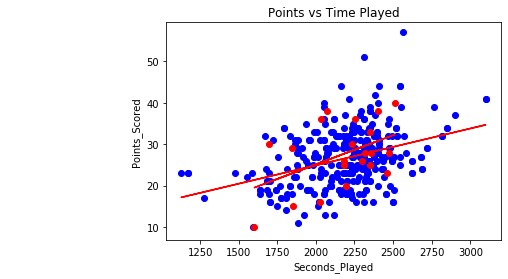

In [18]:

plt.xlabel('Seconds_Played')
plt.ylabel('Points_Scored')
plt.title('Points vs Time Played')
linearregress(X, y, 1, 1)
stats(filter_df['Points'], filter_df)
linearregress2(X_covid, y_covid, 25, 25)
stats(covid_filter['Points'], covid_filter)